# Title

In [173]:
import numpy as np
import pandas as pd
import nltk

nltk.download("stopwords")
nltk.download("words")
import os
import re
import sqlalchemy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Dataset

In [174]:
CWD = os.getcwd()
dataset_engine = sqlalchemy.create_engine(
    f"sqlite:///{CWD}/modeling_dataset.db"
)
dataset_engine.connect()

In [175]:
tables = pd.read_sql(
    "SELECT * FROM sqlite_master WHERE type = 'table'", dataset_engine
)
tables

,type,name,tbl_name,rootpage,sql
0,table,by,by,2,"CREATE TABLE ""by"" (\n\t""index"" BIGINT, \n\tlic..."
1,table,by-sa,by-sa,28,"CREATE TABLE ""by-sa"" (\n\t""index"" BIGINT, \n\t..."
2,table,by-nc,by-nc,410,"CREATE TABLE ""by-nc"" (\n\t""index"" BIGINT, \n\t..."
3,table,by-nc-sa,by-nc-sa,436,"CREATE TABLE ""by-nc-sa"" (\n\t""index"" BIGINT, \..."
4,table,by-nd,by-nd,1223,"CREATE TABLE ""by-nd"" (\n\t""index"" BIGINT, \n\t..."
5,table,by-nc-nd,by-nc-nd,1590,"CREATE TABLE ""by-nc-nd"" (\n\t""index"" BIGINT, \..."
6,table,publicdomain,publicdomain,803,"CREATE TABLE publicdomain (\n\t""index"" BIGINT,..."


In [176]:
webpages_dataset = pd.concat(
    [
        pd.read_sql(f"SELECT * FROM '{table_name}'", dataset_engine)
        for table_name in tables["name"]
    ]
)
webpages_dataset = (
    webpages_dataset.loc[webpages_dataset["contents"] != "", :]
    .reset_index()
    .drop(["index", "title", "level_0"], axis=1)
)
webpages_dataset.sample(5)

,license,url,contents
2571,licenses/by-sa/2.5,https://wiki.osgeo.org/wiki/FOSS4G_2009_Press_...,FOSS4G 2009 Press Release 39 - OSGeo FOSS4G 20...
8563,publicdomain/mark/1.0,https://bmchealthservres.biomedcentral.com/art...,How can healthcare organizations implement pat...
1174,licenses/by/3.0,https://opensource.org/licenses/MIT,The MIT License | Open Source Initiative Skip ...
931,licenses/by/1.0,https://spiral.imperial.ac.uk/handle/10044/1/4...,Spiral: Circadian clocks and breast cancer Ski...
7098,licenses/by-nc-nd/3.0,https://forums.autodesk.com/t5/stingray-forum/...,Solved: creativecommons.org/licenses/by-nc-nd/...


In [177]:
webpages_dataset_deduplicate = (
    webpages_dataset.groupby("url").first().reset_index()
)
webpages_dataset_deduplicate.describe()

,url,license,contents
count,1956,1956,1956
unique,1956,39,1898
top,http://agroportal.lirmm.fr/ontologies/PCO,licenses/by/4.0,403 Forbidden 403 Forbidden nginx
freq,1,136,25


In [178]:
import dataset_sampling

license_map = dataset_sampling.get_license_map()
license_ser = pd.concat([v for v in license_map.values()])
license_ser_splits_df = license_ser.str.split("/", expand=True)
license_ser_splits_df = license_ser_splits_df.rename(
    columns={
        0: "Tool Typing",
        1: "General Typing",
        2: "Version",
        3: "Jurisdiction",
    }
)
license_ser_splits_df["General Typing"] = license_ser_splits_df[
    "General Typing"
].str.replace("mark|zero", "publicdomain", regex=True)
license_ser_splits_df["General Typing"] = license_ser_splits_df[
    "General Typing"
].str.replace("by-nd-nc", "by-nc-nd", regex=True)
license_ser_splits_df["Version"] = license_ser_splits_df["Version"].astype(
    float
)
license_one_hot_encoding = pd.DataFrame()
license_one_hot_encoding["by"] = license_ser_splits_df[
    "General Typing"
].str.contains("by")
license_one_hot_encoding["sa"] = license_ser_splits_df[
    "General Typing"
].str.contains("sa")
license_one_hot_encoding["nc"] = license_ser_splits_df[
    "General Typing"
].str.contains("nc")
license_one_hot_encoding["nd"] = license_ser_splits_df[
    "General Typing"
].str.contains("nd")
license_not_six_type = license_ser_splits_df["General Typing"].str.contains(
    "by|sa|nc|nd"
)
license_one_hot_encoding["neither"] = ~(license_not_six_type.fillna(False))
license_df = pd.concat(
    [license_ser, license_ser_splits_df, license_one_hot_encoding], axis=1
).rename(columns={0: "license"})
license_df.head(6)

,license,Tool Typing,General Typing,Version,by,sa,nc,nd,neither
0,licenses/by/1.0,licenses,by,1.0,True,False,False,False,False
14,licenses/by/2.0,licenses,by,2.0,True,False,False,False,False
27,licenses/by/2.1,licenses,by,2.1,True,False,False,False,False
33,licenses/by/2.5,licenses,by,2.5,True,False,False,False,False
39,licenses/by/3.0,licenses,by,3.0,True,False,False,False,False
45,licenses/by/4.0,licenses,by,4.0,True,False,False,False,False


In [179]:
webpages_dataset_deduplicate = webpages_dataset_deduplicate.merge(
    license_df, on="license"
)
webpages_dataset_deduplicate.sample(5)

,url,license,contents,Tool Typing,General Typing,Version,by,sa,nc,nd,neither
1121,https://jhoonline.biomedcentral.com/articles/1...,licenses/by/2.1,Hemolysis and hyperhomocysteinemia caused by c...,licenses,by,2.1,True,False,False,False,False
956,https://www.scottish-country-dancing-dictionar...,licenses/by-sa/1.0,"Domino Five, Scottish Country Dance Instructio...",licenses,by-sa,1.0,True,True,False,False,False
1406,https://geoservice.dlr.de/catalogue/srv/api/re...,licenses/by-nc/1.0,3a597007-fe7d-4f02-8a7b-d77529558046 Dataserie...,licenses,by-nc,1.0,True,False,True,False,False
1446,https://docs.opengeospatial.org/cs/17-002r1/17...,licenses/by/1.0,OGC 17-002r1: OGC GeoRSS Encoding Standard Ope...,licenses,by,1.0,True,False,False,False,False
1165,https://textbooks.whatcom.edu/bus230/chapter/2...,licenses/by/2.1,2.1 Strategic Planning – Human Resource Manage...,licenses,by,2.1,True,False,False,False,False


In [180]:
webpages_dataset_deduplicate.groupby("General Typing").count()

,url,license,contents,Tool Typing,Version,by,sa,nc,nd,neither
General Typing,,,,,,,,,,
by,751,751,751,751,751,751,751,751,751,751
by-nc,242,242,242,242,242,242,242,242,242,242
by-nc-nd,117,117,117,117,117,117,117,117,117,117
by-nc-sa,201,201,201,201,201,201,201,201,201,201
by-nd,131,131,131,131,131,131,131,131,131,131
by-sa,280,280,280,280,280,280,280,280,280,280
publicdomain,234,234,234,234,234,234,234,234,234,234


In [181]:
# webpages_dataset_deduplicate["contents"] = webpages_dataset_deduplicate["contents"].apply(lambda x: x[:3000])

In [182]:
import string


def remove_unicodes(ser):
    return ser.map(lambda x: " ".join([c for c in x if c in string.printable]))


def has_unicodes(s, tolerance=30):
    return np.sum([c not in string.printable for c in s]) <= tolerance


def not_well_decrypted(s, tolerance=25):
    words = re.split(r"\s+", s)
    return np.sum([len(c) == 1 for c in words]) <= tolerance


def remove_unicodes_aggressive(df, field_name="contents"):
    df_remove_unicode = df.loc[df[field_name].apply(has_unicodes), :]
    return df_remove_unicode

In [183]:
# Less Aggressive pruning
# webpages_dataset_deduplicate["parsed_contents"] = remove_unicodes(webpages_dataset_deduplicate["contents"])
# webpages_dataset_deduplicate.loc[1149, ["contents", "parsed_contents"]]

# More Aggressive pruning
webpages_dataset_deduplicate = remove_unicodes_aggressive(
    webpages_dataset_deduplicate
)

In [184]:
def remove_less_than_c_chars(s, tolerance=2):
    words = re.split(r"\s+", s)
    return " ".join([c for c in words if len(c) > tolerance])


def remove_more_than_c_chars(s, tolerance=15):
    words = re.split(r"\s+", s)
    return " ".join([c for c in words if len(c) <= tolerance])


def remove_non_english(s):
    words = set(nltk.corpus.words.words())
    return " ".join(w for w in re.split(r"\s+", s) if w in words)


def remove_web_urls(s):
    return re.sub(
        r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        " ",
        s,
    )


def clear_stopwords(s):
    return " ".join(
        [
            word
            for word in re.split(r"\s+", s)
            if word.lower() not in nltk.corpus.stopwords.words("english")
        ]
    )


def clear_stopwords_series(ser):
    return ser.apply(clear_stopwords)


def overall_cleaning(ser):
    cleaned_ser = ser.str.lower()
    cleaned_ser = cleaned_ser.apply(remove_web_urls)
    cleaned_ser = cleaned_ser.str.replace(r"[^A-Za-z\s]", " ", regex=True)
    cleaned_ser = cleaned_ser.str.replace(r"\s+", " ", regex=True)
    cleaned_ser = cleaned_ser.apply(clear_stopwords)
    cleaned_ser = cleaned_ser.apply(remove_less_than_c_chars)
    cleaned_ser = cleaned_ser.apply(remove_non_english)
    cleaned_ser = cleaned_ser.apply(clear_stopwords)
    # cleaned_ser = cleaned_ser.apply(remove_more_than_c_chars)
    return cleaned_ser


webpages_dataset_deduplicate["cleaned_contents"] = overall_cleaning(
    webpages_dataset_deduplicate["contents"]
)
webpages_dataset_deduplicate = webpages_dataset_deduplicate.loc[
    webpages_dataset_deduplicate["cleaned_contents"].str.len() >= 500, :
]
# webpages_dataset_deduplicate["parsed_cleaned_contents"] = clear_stopwords_series(webpages_dataset_deduplicate["cleaned_contents"])

In [185]:
for row in webpages_dataset_deduplicate["cleaned_contents"].sample(5):
    print(f"Entry content:\n{row[:550]}\n")

Entry content:
natural color photograph right arm posterior view showing artery vein nerve long head triceps muscle retracted skip main content search two million university southern digital library surgical anatomy teaching collection natural color photograph right arm posterior view showing artery vein nerve long head triceps muscle retracted image natural color photograph right arm posterior view showing artery vein view source image contributor get citation recommend include following information citation look item additional data may want include title n

Entry content:
generalized granuloma relapse non king home search browse account digital commons network skip main content safety index digital commons east state university home account previous next home faculty works works faculty works title generalized granuloma relapse non lymphoma creator king east state university east state university follow east state university earl brown east state university east state university doc

## Preprocessing

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import top_k_accuracy_score
from sklearn.decomposition import PCA
import re
from imblearn.over_sampling import SMOTE

In [187]:
def tokenize_url(url):
    return " ".join(re.split(r"[_/\.-]", re.sub(r"\d", "", url)))


tokenize_url("creativecommons.org/licenses/by-sa/4.0")

'creativecommons org licenses by sa  '

In [188]:
dataset = webpages_dataset_deduplicate.copy()
dataset["token_url"] = dataset["url"].apply(tokenize_url)
dataset["train_text"] = (
    dataset["token_url"] + " " + dataset["cleaned_contents"]
)

## Modeling

In [189]:
def extract_text_features_tfidf(
    train, test, text_field="train_text", svd=True
):
    tfidf_vectorizer = TfidfVectorizer(
        use_idf=True,
        stop_words="english",
        max_features=6500,
        max_df=0.95,
        sublinear_tf=True,
        ngram_range=(1, 3),
    )
    tfidf_vectorizer.fit(train[text_field].values)
    train_vectorized = tfidf_vectorizer.transform(train[text_field].values)
    test_vectorized = tfidf_vectorizer.transform(test[text_field].values)
    svd_train, svd_test = None, None
    if svd:
        tsvd = TruncatedSVD(n_components=100)
        tsvd.fit(train_vectorized)
        svd_train = tsvd.transform(train_vectorized)
        svd_test = tsvd.transform(test_vectorized)
    return train_vectorized, test_vectorized, svd_train, svd_test


# tolerance 1 -> 7500, 500

In [190]:
model_dataset = pd.DataFrame()
dataset_counts = (
    dataset.groupby("General Typing")[["url"]].count().reset_index()["url"]
)
license_dict = {
    "by": 0,
    "by-nc": 1,
    "by-nc-nd": 2,
    "by-nc-sa": 3,
    "by-nd": 4,
    "by-sa": 5,
    "publicdomain": 6,
}

model_dataset["train_text"], model_dataset["General Typing"] = (
    dataset["cleaned_contents"],
    dataset["General Typing"],
)
model_dataset["General Typing"].replace(license_dict, inplace=True)

training_set, test_set = train_test_split(
    model_dataset, test_size=0.2, random_state=10
)
Y_train = training_set["General Typing"].values
Y_test = test_set["General Typing"].values
X_train, X_test, svd_X_train, svd_X_test = extract_text_features_tfidf(
    training_set, test_set
)
smote_strat = {
    k: int(
        0.8
        * min(
            round(np.mean(dataset_counts.values)), dataset_counts.iloc[k] * 1.8
        )
    )
    for k in range(1, 7)
}
svd_Y_train = Y_train.copy()

smote = SMOTE(sampling_strategy=smote_strat)
X_train, Y_train = smote.fit_resample(X_train, Y_train)
smote_svd = SMOTE(sampling_strategy=smote_strat)
svd_X_train, svd_Y_train = smote_svd.fit_resample(svd_X_train, svd_Y_train)

### log reg

In [162]:
model_logreg = LogisticRegression(
    verbose=0, penalty="l2", solver="liblinear", class_weight="balanced", C=0.1
).fit(X_train, Y_train)

In [163]:
print(
    top_k_accuracy_score(Y_train, model_logreg.predict_proba(X_train), k=1),
    "\n",
    top_k_accuracy_score(Y_train, model_logreg.predict_proba(X_train), k=2),
    "\n",
    top_k_accuracy_score(Y_train, model_logreg.predict_proba(X_train), k=3),
    "\n==============\n",
    top_k_accuracy_score(Y_test, model_logreg.predict_proba(X_test), k=1),
    "\n",
    top_k_accuracy_score(Y_test, model_logreg.predict_proba(X_test), k=2),
    "\n",
    top_k_accuracy_score(Y_test, model_logreg.predict_proba(X_test), k=3),
)

0.5948148148148148 
 0.8688888888888889 
 0.9466666666666667 
 0.49825783972125437 
 0.7142857142857143 
 0.8083623693379791


### SVM

In [164]:
model_svc = SVC(
    C=0.5,
    verbose=1,
    probability=True,
    kernel="poly",
    degree=1,
    class_weight="balanced",
).fit(svd_X_train, svd_Y_train)

[LibSVM]

In [165]:
print(
    top_k_accuracy_score(
        svd_Y_train, model_svc.predict_proba(svd_X_train), k=1
    ),
    "\n",
    top_k_accuracy_score(
        svd_Y_train, model_svc.predict_proba(svd_X_train), k=2
    ),
    "\n",
    top_k_accuracy_score(
        svd_Y_train, model_svc.predict_proba(svd_X_train), k=3
    ),
    "\n==============\n",
    top_k_accuracy_score(Y_test, model_svc.predict_proba(svd_X_test), k=1),
    "\n",
    top_k_accuracy_score(Y_test, model_svc.predict_proba(svd_X_test), k=2),
    "\n",
    top_k_accuracy_score(Y_test, model_svc.predict_proba(svd_X_test), k=3),
)

0.542962962962963 
 0.7518518518518519 
 0.8674074074074074 
 0.4878048780487805 
 0.6794425087108014 
 0.8048780487804879


### MultiNB

In [166]:
model_mnb = MultinomialNB(fit_prior=True, alpha=10).fit(X_train, Y_train)

In [167]:
print(
    top_k_accuracy_score(Y_train, model_mnb.predict_proba(X_train), k=1),
    "\n",
    top_k_accuracy_score(Y_train, model_mnb.predict_proba(X_train), k=2),
    "\n",
    top_k_accuracy_score(Y_train, model_mnb.predict_proba(X_train), k=3),
    "\n==============\n",
    top_k_accuracy_score(Y_test, model_mnb.predict_proba(X_test), k=1),
    "\n",
    top_k_accuracy_score(Y_test, model_mnb.predict_proba(X_test), k=2),
    "\n",
    top_k_accuracy_score(Y_test, model_mnb.predict_proba(X_test), k=3),
)

0.3333333333333333 
 0.7214814814814815 
 0.8192592592592592 
 0.40069686411149824 
 0.6724738675958188 
 0.7665505226480837


### What Berkeley does to an RF

In [168]:
model_rfc = RandomForestClassifier(
    class_weight="balanced_subsample", n_estimators=100, random_state=1
).fit(X_train, Y_train)

In [169]:
print(
    top_k_accuracy_score(Y_train, model_rfc.predict_proba(X_train), k=1),
    "\n",
    top_k_accuracy_score(Y_train, model_rfc.predict_proba(X_train), k=2),
    "\n",
    top_k_accuracy_score(Y_train, model_rfc.predict_proba(X_train), k=3),
    "\n==============\n",
    top_k_accuracy_score(Y_test, model_rfc.predict_proba(X_test), k=1),
    "\n",
    top_k_accuracy_score(Y_test, model_rfc.predict_proba(X_test), k=2),
    "\n",
    top_k_accuracy_score(Y_test, model_rfc.predict_proba(X_test), k=3),
)

0.9977777777777778 
 0.9992592592592593 
 1.0 
 0.5296167247386759 
 0.7421602787456446 
 0.8327526132404182


### GBC???? Golden Bear Cafe? No, Gradient Boosting Classifier.

In [170]:
model_gbc = GradientBoostingClassifier(n_estimators=50, random_state=1).fit(
    X_train, Y_train
)

In [171]:
print(
    top_k_accuracy_score(Y_train, model_gbc.predict_proba(X_train), k=1),
    "\n",
    top_k_accuracy_score(Y_train, model_gbc.predict_proba(X_train), k=2),
    "\n",
    top_k_accuracy_score(Y_train, model_gbc.predict_proba(X_train), k=3),
    "\n==============\n",
    top_k_accuracy_score(Y_test, model_gbc.predict_proba(X_test), k=1),
    "\n",
    top_k_accuracy_score(Y_test, model_gbc.predict_proba(X_test), k=2),
    "\n",
    top_k_accuracy_score(Y_test, model_gbc.predict_proba(X_test), k=3),
)

0.9022222222222223 
 0.9859259259259259 
 0.997037037037037 
 0.5087108013937283 
 0.6933797909407665 
 0.794425087108014


### Tensorflow

In [374]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel("ERROR")

In [375]:
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"
)
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [941]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 8
TRAINING_RATIO = 0.8

model_dataset = dataset.loc[:, ["cleaned_contents", "General Typing"]]
model_dataset["General Typing"].replace(license_dict, inplace=True)

model_dataset_copy = model_dataset[
    ~model_dataset["General Typing"].isin([2, 4])
]

target = model_dataset_copy.pop("General Typing")
# dataset_tensor = tf.convert_to_tensor(model_dataset, dtype=np.string_)
tf_dataset = tf.data.Dataset.from_tensor_slices(
    (model_dataset_copy, target)
).shuffle(50)
train_dataset = tf_dataset.take(int(TRAINING_RATIO * len(tf_dataset)))
test_dataset = tf_dataset.skip(int(TRAINING_RATIO * len(tf_dataset)))
val_dataset = test_dataset.skip(
    int((1 - TRAINING_RATIO) * 0.5 * len(tf_dataset))
)
test_dataset = test_dataset.take(
    int((1 - TRAINING_RATIO) * 0.5 * len(tf_dataset))
)

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [946]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name="parsed_cleaned_contents"
    )
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation=None, name="classifier")(net)
    return tf.keras.Model(text_input, net)

In [947]:
from tensorflow_addons.metrics import F1Score

In [948]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

In [949]:
classifier_model = build_classifier_model()
classifier_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Score(1, average="weighted")],
)
history = classifier_model.fit(
    train_dataset, validation_data=val_dataset, epochs=epochs
)

Epoch 1/10
135/135 [==============================] - 129s 905ms/step - loss: 2.5825e-07 - accuracy: 0.3113 - f1_score: 1.3684 - val_loss: 3.3467e-07 - val_accuracy: 0.1926 - val_f1_score: 1.4747
Epoch 2/10
135/135 [==============================] - 119s 885ms/step - loss: 2.5936e-07 - accuracy: 0.2955 - f1_score: 1.3702 - val_loss: 3.4085e-07 - val_accuracy: 0.2000 - val_f1_score: 1.4818
Epoch 3/10
135/135 [==============================] - 115s 855ms/step - loss: 2.5847e-07 - accuracy: 0.2974 - f1_score: 1.3687 - val_loss: 3.4438e-07 - val_accuracy: 0.2148 - val_f1_score: 1.4857
Epoch 4/10
130/135 [===========================>..] - ETA: 4s - loss: 2.6536e-07 - accuracy: 0.2769 - f1_score: 1.3800

KeyboardInterrupt: 

## Model Performance Evaluation

In [290]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### General Operations

In [230]:
def generate_datasets():
    model_dataset = pd.DataFrame()
    dataset_counts = (
        dataset.groupby("General Typing")[["url"]].count().reset_index()["url"]
    )
    license_dict = {
        "by": 0,
        "by-nc": 1,
        "by-nc-nd": 2,
        "by-nc-sa": 3,
        "by-nd": 4,
        "by-sa": 5,
        "publicdomain": 6,
    }

    model_dataset["train_text"], model_dataset["General Typing"] = (
        dataset["cleaned_contents"],
        dataset["General Typing"],
    )
    model_dataset["General Typing"].replace(license_dict, inplace=True)

    training_set, test_set = train_test_split(
        model_dataset, test_size=0.2, random_state=10
    )
    Y_train = training_set["General Typing"].values
    Y_test = test_set["General Typing"].values
    X_train, X_test, svd_X_train, svd_X_test = extract_text_features_tfidf(
        training_set, test_set
    )
    smote_strat = {
        k: int(
            0.8
            * min(
                round(np.mean(dataset_counts.values)),
                dataset_counts.iloc[k] * 1.8,
            )
        )
        for k in range(1, 7)
    }
    svd_Y_train = Y_train.copy()

    smote = SMOTE(sampling_strategy=smote_strat)
    X_train, Y_train = smote.fit_resample(X_train, Y_train)
    smote_svd = SMOTE(sampling_strategy=smote_strat)
    svd_X_train, svd_Y_train = smote_svd.fit_resample(svd_X_train, svd_Y_train)
    return (
        X_train,
        Y_train,
        svd_X_train,
        svd_Y_train,
        X_test,
        Y_test,
        svd_X_test,
    )

In [249]:
def get_n_accuracies(model, num_iter=100, svd=False):
    training_accuracies = []
    testing_accuracies = []
    for _ in range(num_iter):
        (
            X_train,
            Y_train,
            svd_X_train,
            svd_Y_train,
            X_test,
            Y_test,
            svd_X_test,
        ) = generate_datasets()
        if svd:
            X_train = svd_X_train
            Y_train = svd_Y_train
            X_test = svd_X_test
        cur_model = model.fit(X_train, Y_train)
        training_accuracies.append(
            [
                top_k_accuracy_score(
                    Y_train, cur_model.predict_proba(X_train), k=i
                )
                for i in range(1, 4)
            ]
        )
        testing_accuracies.append(
            [
                top_k_accuracy_score(
                    Y_test, cur_model.predict_proba(X_test), k=i
                )
                for i in range(1, 4)
            ]
        )
        if _ % 25 == 24:
            print(f"DEBUG, {str(model)} has finished {_ + 1} measurements")
    return training_accuracies, testing_accuracies


def conf_interval(arr, conf=0.95):
    conf_pad = (1 - conf) * 0.5
    return (np.percentile(arr, conf_pad), np.percentile(arr, 1 - conf_pad))

1. Get all models' 100 trial results
2. From 100 trial results, plot model specific situations and comparisons on each level of top k.

In [250]:
model_dict = {
    "Logistic Regression": LogisticRegression(
        penalty="l2", solver="liblinear", class_weight="balanced", C=0.1
    ),
    "Support Vector Machine": SVC(
        C=0.5,
        probability=True,
        kernel="poly",
        degree=1,
        class_weight="balanced",
    ),
    "Multinomial Naive Bayes": MultinomialNB(fit_prior=True, alpha=10),
    "Random Forest (Ensemble)": RandomForestClassifier(
        class_weight="balanced_subsample", n_estimators=100, random_state=1
    ),
    "Gradient Boost (Ensemble)": GradientBoostingClassifier(
        n_estimators=50, random_state=1
    ),
}

In [251]:
model_train_accs = {k: [] for k in model_dict}
model_test_accs = {k: [] for k in model_dict}
for k in model_dict:
    if k == "Support Vector Machine":
        accuracy_measurements = get_n_accuracies(model_dict[k], svd=True)
    else:
        accuracy_measurements = get_n_accuracies(model_dict[k])
    model_train_accs[k] = accuracy_measurements[0]
    model_test_accs[k] = accuracy_measurements[1]

DEBUG, LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear') has finished 25 measurements
DEBUG, LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear') has finished 50 measurements
DEBUG, LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear') has finished 75 measurements
DEBUG, LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear') has finished 100 measurements
DEBUG, SVC(C=0.5, class_weight='balanced', degree=1, kernel='poly', probability=True) has finished 25 measurements
DEBUG, SVC(C=0.5, class_weight='balanced', degree=1, kernel='poly', probability=True) has finished 50 measurements
DEBUG, SVC(C=0.5, class_weight='balanced', degree=1, kernel='poly', probability=True) has finished 75 measurements
DEBUG, SVC(C=0.5, class_weight='balanced', degree=1, kernel='poly', probability=True) has finished 100 measurements
DEBUG, MultinomialNB(alpha=10) has finished 25 measurements
DEBUG, MultinomialNB(alpha=10) has finished 50 mea

In [252]:
def create_accuracy_frame(acc_arr):
    cols = {"k = 1": [], "k = 2": [], "k = 3": []}
    for row in acc_arr:
        cols["k = 1"].append(row[0])
        cols["k = 2"].append(row[1])
        cols["k = 3"].append(row[2])
    return pd.DataFrame(cols)

In [260]:
train_accuracy_frames = {
    k: [create_accuracy_frame(model_train_accs[k])] for k in model_train_accs
}
test_accuracy_frames = {
    k: [create_accuracy_frame(model_test_accs[k])] for k in model_test_accs
}

In [262]:
train_accuracy_frames["Logistic Regression"]

[       k = 1     k = 2     k = 3
 0   0.588148  0.853333  0.940741
 1   0.585926  0.857037  0.940741
 2   0.588148  0.865926  0.940741
 3   0.597778  0.859259  0.945185
 4   0.570370  0.857778  0.945926
 ..       ...       ...       ...
 95  0.577037  0.849630  0.952593
 96  0.585185  0.847407  0.940000
 97  0.588148  0.851852  0.937778
 98  0.600741  0.857037  0.940000
 99  0.591852  0.845185  0.943704
 
 [100 rows x 3 columns]]

### Visualizing Performances

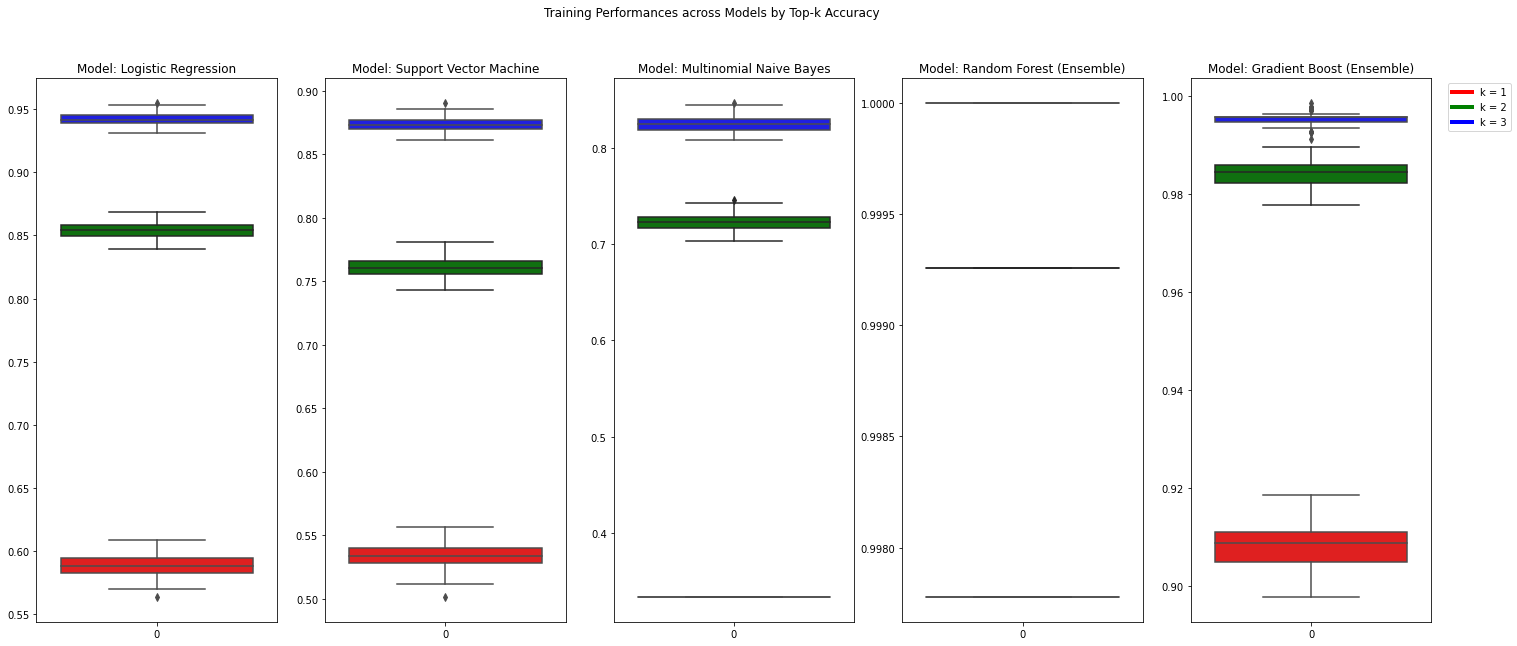

In [321]:
subplot_num = 0

plt.rcParams["figure.facecolor"] = "white"
fig, axs = plt.subplots(1, 5, figsize=(25, 10))
for k in train_accuracy_frames:
    sns.boxplot(
        train_accuracy_frames[k][0]["k = 1"],
        ax=axs[subplot_num],
        color="red",
        labels=["k = 1"],
    )
    sns.boxplot(
        train_accuracy_frames[k][0]["k = 2"],
        ax=axs[subplot_num],
        color="green",
        labels=["k = 2"],
    )
    sns.boxplot(
        train_accuracy_frames[k][0]["k = 3"],
        ax=axs[subplot_num],
        color="blue",
        labels=["k = 3"],
    )
    axs[subplot_num].set_title(f"Model: {k}")
    subplot_num += 1
legend_elements = [
    Line2D([0], [0], color="red", lw=4, label="k = 1"),
    Line2D([0], [0], color="green", lw=4, label="k = 2"),
    Line2D([0], [0], color="blue", lw=4, label="k = 3"),
]
plt.suptitle("Training Performances across Models by Top-k Accuracy")
plt.legend(
    handles=legend_elements, loc="upper right", bbox_to_anchor=(1.35, 1)
)

plt.rcParams["figure.facecolor"] = "white"

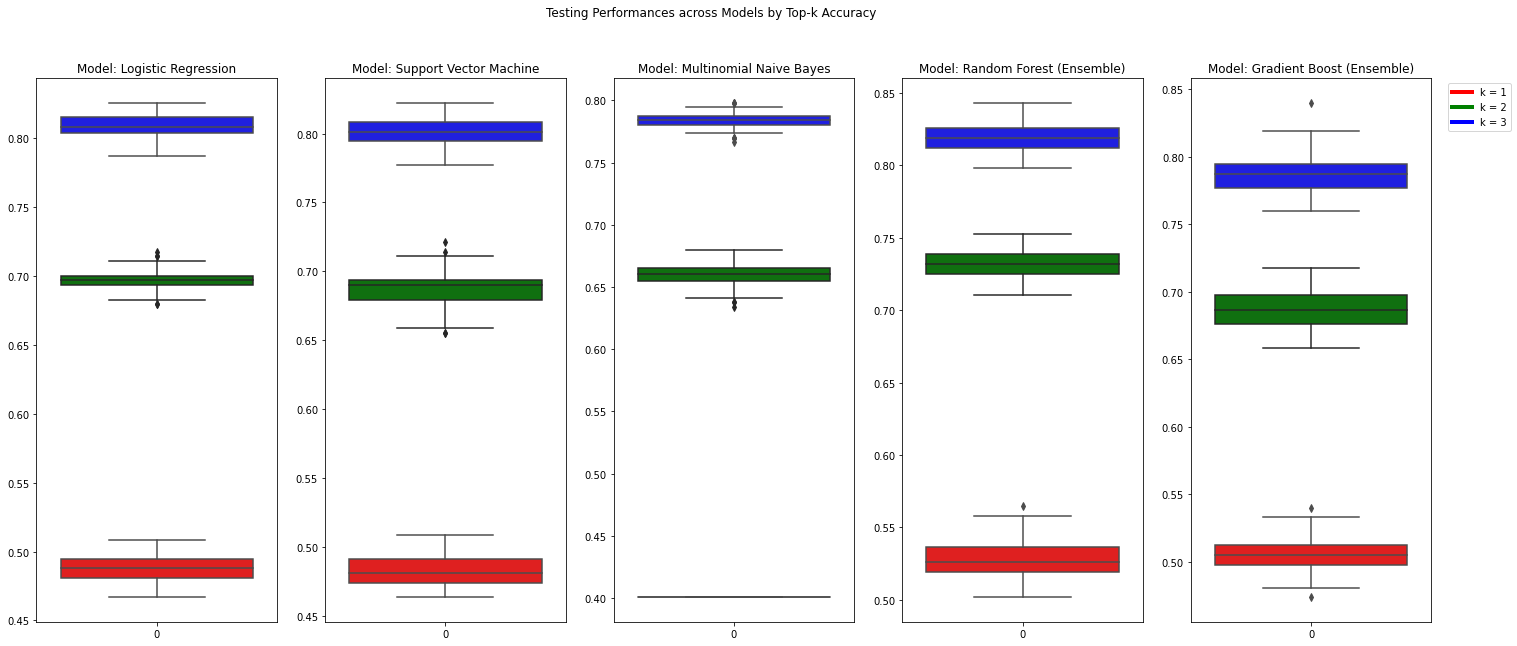

In [323]:
subplot_num = 0

plt.rcParams["figure.facecolor"] = "white"
fig, axs = plt.subplots(1, 5, figsize=(25, 10))
for k in test_accuracy_frames:
    sns.boxplot(
        test_accuracy_frames[k][0]["k = 1"],
        ax=axs[subplot_num],
        color="red",
        labels=["k = 1"],
    )
    sns.boxplot(
        test_accuracy_frames[k][0]["k = 2"],
        ax=axs[subplot_num],
        color="green",
        labels=["k = 2"],
    )
    sns.boxplot(
        test_accuracy_frames[k][0]["k = 3"],
        ax=axs[subplot_num],
        color="blue",
        labels=["k = 3"],
    )
    axs[subplot_num].set_title(f"Model: {k}")
    subplot_num += 1
legend_elements = [
    Line2D([0], [0], color="red", lw=4, label="k = 1"),
    Line2D([0], [0], color="green", lw=4, label="k = 2"),
    Line2D([0], [0], color="blue", lw=4, label="k = 3"),
]
plt.suptitle("Testing Performances across Models by Top-k Accuracy")
plt.legend(
    handles=legend_elements, loc="upper right", bbox_to_anchor=(1.35, 1)
)

plt.rcParams["figure.facecolor"] = "white"

In [327]:
import os

CWD = os.getcwd()

In [329]:
for k in train_accuracy_frames:
    train_accuracy_frames[k][0].describe().to_csv(
        f"{CWD}/model_results/train/{k.replace(' ', '')}.csv"
    )

In [330]:
for k in test_accuracy_frames:
    test_accuracy_frames[k][0].describe().to_csv(
        f"{CWD}/model_results/test/{k.replace(' ', '')}.csv"
    )